# 基于卷积神经网络的手写英文字母识别系统研究

## 准备数据集及数据预处理

### 将下载的数据集按类重命名

In [3]:

# import os
# import string
#
# # 定义源目录路径
# source_dir = "EnglishHnd/EnglishHnd/English/Hnd/Img"
#
# # 生成目标文件夹名称列表
# target_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]
#
# # 获取源目录下的所有文件夹名称
# source_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])
#
# # 确保源文件夹数量与目标文件夹数量一致
# if len(source_folders) != len(target_folders):
#     raise ValueError("源文件夹数量与目标文件夹数量不一致")
#
# # 重命名文件夹
# for source_folder, target_folder in zip(source_folders, target_folders):
#     source_path = os.path.join(source_dir, source_folder)
#     target_path = os.path.join(source_dir, target_folder)
#
#     try:
#         os.rename(source_path, target_path)
#         print(f"重命名: {source_path} -> {target_path}")
#     except FileExistsError:
#         print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")
#     except Exception as e:
#         print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")


### 划分训练集和测试集

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
#数据增强
from albumentations.pytorch import ToTensorV2
import albumentations as A
from myCnn.baseline.LeNet5 import LeNet5
from myCnn.train_model import train_model
from myCnn.utils import split_dataset
from myCnn.baseline.resnet18 import resnet18
from myCnn.baseline.mobilenet_v2 import mobilenet_v2
from myCnn.evaluate_model import evaluate_model
from myCnn.utils import plot_comparison
from myCnn.cnnWithAttention.attentionStructure import CNNWithAttention
from myCnn.cnnWithAttention.train_my_cnn import train_and_validate
EPOCH = 500
BATCH_SIZE = 128
LR = 1e-4

In [5]:
# # 定义数据预处理变换
# transform = T.Compose([
#     T.Resize((64, 64)),
#     T.Grayscale(num_output_channels=3),
#     T.RandomRotation(15),  # 数据增强：随机旋转
#     T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 位移
#     T.ToTensor(),
#     # 如果需要标准化，可以取消注释以下行
#     T.Normalize([0.5], [0.5])
# ])
class AlbumentationsTransform:
    def __init__(self):
        self.transform=A.Compose([
            A.Resize(28, 28),
            A.Rotate(limit=15, p=0.5),
            A.Affine(translate_percent=(0.1,0.1),p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.5,),std=(0.5,)),
            ToTensorV2()
        ])
    def __call__(self, img):
        img=np.array(img)
        # img = np.array(img.convert('L'))
        return self.transform(image=img)['image']

transform=AlbumentationsTransform()


训练集大小: 25900
验证集大小: 5550
测试集大小: 5550
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'a_': 26, 'b_': 27, 'd_': 28, 'e_': 29, 'f_': 30, 'g_': 31, 'h_': 32, 'n_': 33, 'q_': 34, 'r_': 35, 't_': 36}


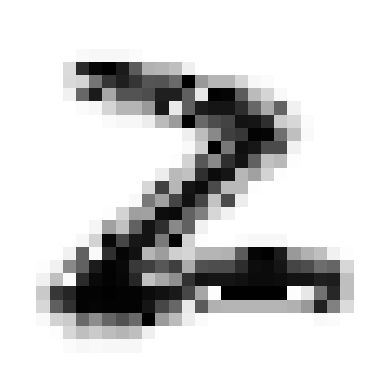

In [6]:
# 使用函数划分数据集
train_loader, val_loader, test_loader, full_dataset = split_dataset(
    root_dir="emnist_png_balanced",
    # root_dir="EnglishImg/EnglishImg/English/Img/GoodImg/Bmp",
    transform=transform,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    batch_size=BATCH_SIZE,
    shuffle=True,
    random_seed=42
)

# 打印数据集大小
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"验证集大小: {len(val_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

# 获取类别数量
label_num = len(full_dataset.class_to_idx)
print(full_dataset.class_to_idx)
# 数据可视化
to_img = T.ToPILImage()
a = to_img(train_loader.dataset[0][0])  # size=[1, 28, 28]
plt.imshow(a)
plt.axis('off')
plt.show()


# 获取类别数量
label_num = len(full_dataset.class_to_idx)

In [7]:

# # 获取展平后的训练集和验证集
# X_train, y_train = flatten_images(train_loader)
# X_val, y_val = flatten_images(val_loader)

In [8]:

# # 训练SVM模型
# svm_clf, train_acc, val_acc = train_svm(X_train, y_train, X_val, y_val)

In [9]:

# 初始化模型
resnet18 = resnet18(num_classes=label_num)
mobilenet_v2 = mobilenet_v2(num_classes=label_num)
LeNet5 = LeNet5(num_classes=label_num)
cnn_with_attention = CNNWithAttention(num_classes=label_num,use_attention=True)

# 加载最好的权重模型

# resnet18.load_state_dict(torch.load('best_model_resnet18.pth'))
# mobilenet_v2.load_state_dict(torch.load('best_model_mobilenet_v2.pth'))
# LeNet5.load_state_dict(torch.load('best_model_LeNet5.pth'))


# 检查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)  # 将模型迁移到 GPU
mobilenet_v2.to(device)
LeNet5.to(device)
cnn_with_attention.to(device)


CNNWithAttention(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05,

In [10]:

# 假设使用cpu
# cnn.to('cpu')

# 创建优化器
optimizer_resnet18 = torch.optim.AdamW(resnet18.parameters(), lr=3e-4, weight_decay=0.05)
optimizer_mobilenet_v2 = torch.optim.AdamW(mobilenet_v2.parameters(), lr=3e-4, weight_decay=0.05)
optimizer_LeNet5 = torch.optim.AdamW(LeNet5.parameters(), lr=3e-4, weight_decay=0.05)
optimizer_cnn_with_attention = torch.optim.AdamW(cnn_with_attention.parameters(), lr=1e-4, weight_decay=0.05)



# 定义损失函数
loss_func = nn.CrossEntropyLoss()

Epoch [1/500] Loss: 1.5955, Train Top-1 Acc: 0.5738, Train Top-3 Acc: 0.7671, Val Top-1 Acc: 0.7795, Val Top-3 Acc: 0.9373
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.7795
Epoch [2/500] Loss: 0.5964, Train Top-1 Acc: 0.8195, Train Top-3 Acc: 0.9563, Val Top-1 Acc: 0.8432, Val Top-3 Acc: 0.9631
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.8432
Epoch [3/500] Loss: 0.4410, Train Top-1 Acc: 0.8610, Train Top-3 Acc: 0.9729, Val Top-1 Acc: 0.8544, Val Top-3 Acc: 0.9739
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.8544
Epoch [4/500] Loss: 0.3654, Train Top-1 Acc: 0.8805, Train Top-3 Acc: 0.9806, Val Top-1 Acc: 0.8766, Val Top-3 Acc: 0.9768
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.8766
Epoch [5/500] Loss: 0.3243, Train Top-1 Acc: 0.8953, Train Top-3 Acc: 0.9851, Val Top-1 Acc: 0.8775, Val Top-3 Acc: 0.9834
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.8775
Epoch [6/500] Loss: 0.2918, Train Top-1 Acc: 0.9018, Train Top-3 Acc: 0.9883, Val Top-1 Acc: 0.8840, Val Top-3 Acc: 0.9832
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.8840
Epoch [7/500] Loss: 0.2686, Train Top-1 Acc: 0.9078, Train

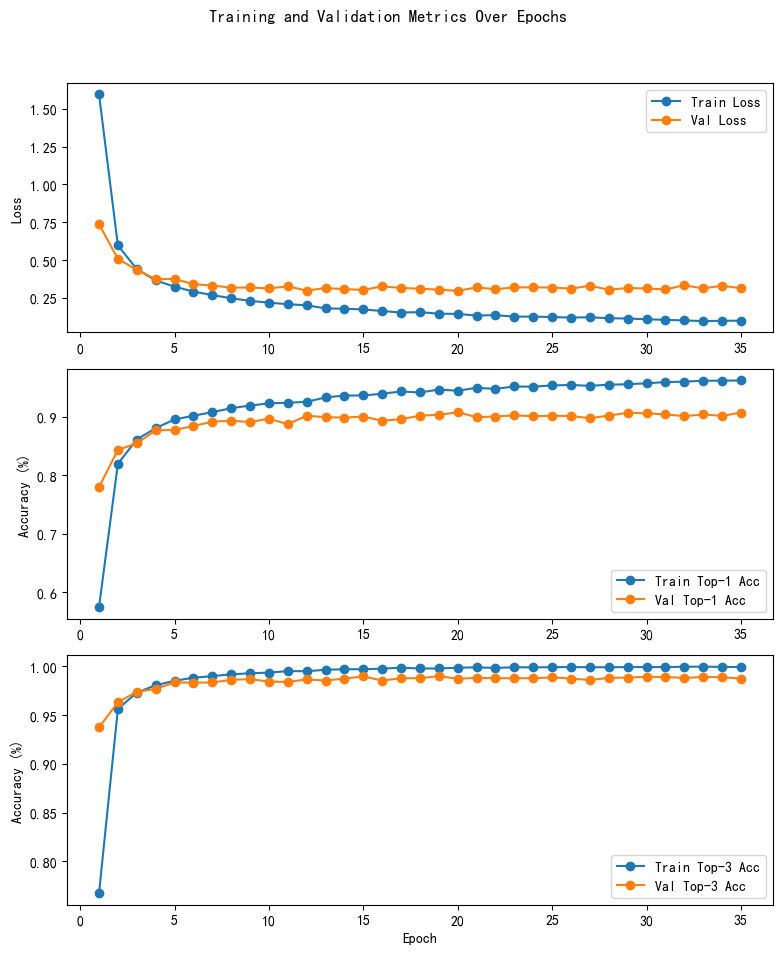

Saved final training metrics plot to training_plots\20250422_225742_training_metrics.png


In [11]:
# 训练模型
resnet18 = train_and_validate(model=resnet18,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCH,
    device=device,
    save_path="best_model_resnet18.pth",
    lr=LR)


Epoch [1/500] Loss: 3.5505, Train Top-1 Acc: 0.0498, Train Top-3 Acc: 0.1372, Val Top-1 Acc: 0.0836, Val Top-3 Acc: 0.2263
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.0836
Epoch [2/500] Loss: 3.1668, Train Top-1 Acc: 0.1284, Train Top-3 Acc: 0.3002, Val Top-1 Acc: 0.1932, Val Top-3 Acc: 0.4040
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.1932
Epoch [3/500] Loss: 2.7062, Train Top-1 Acc: 0.2232, Train Top-3 Acc: 0.4598, Val Top-1 Acc: 0.2822, Val Top-3 Acc: 0.5369
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.2822
Epoch [4/500] Loss: 2.2709, Train Top-1 Acc: 0.3317, Train Top-3 Acc: 0.6003, Val Top-1 Acc: 0.3886, Val Top-3 Acc: 0.6587
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.3886
Epoch [5/500] Loss: 1.9121, Train Top-1 Acc: 0.4263, Train Top-3 Acc: 0.7010, Val Top-1 Acc: 0.4741, Val Top-3 Acc: 0.7481
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.4741
Epoch [6/500] Loss: 1.6256, Train Top-1 Acc: 0.5066, Train Top-3 Acc: 0.7768, Val Top-1 Acc: 0.5458, Val Top-3 Acc: 0.8146
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.5458
Epoch [7/500] Loss: 1.4060, Train Top-1 Acc: 0.5700, Train

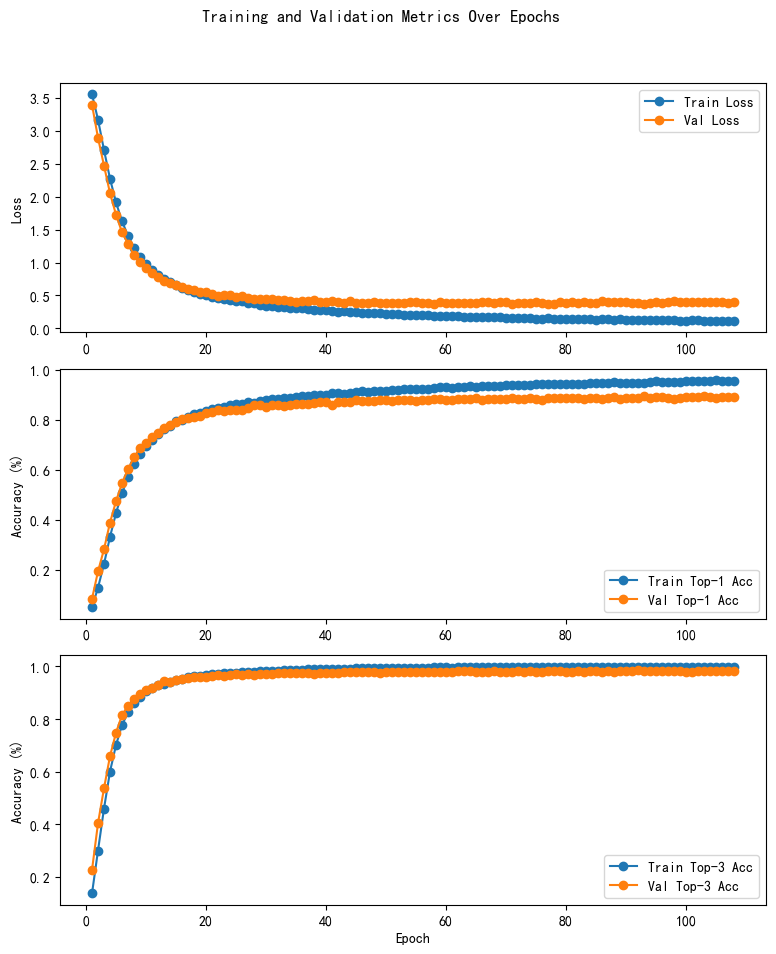

Saved final training metrics plot to training_plots\20250422_232429_training_metrics.png


In [12]:
mobilenet_v2 = train_and_validate(model=mobilenet_v2,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCH,
    device=device,
    save_path="best_model_mobilenet_v2.pth",
    lr=LR)


Epoch [1/500] Loss: 3.4429, Train Top-1 Acc: 0.0849, Train Top-3 Acc: 0.2118, Val Top-1 Acc: 0.2076, Val Top-3 Acc: 0.4551
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.2076
Epoch [2/500] Loss: 2.4432, Train Top-1 Acc: 0.3289, Train Top-3 Acc: 0.5801, Val Top-1 Acc: 0.3845, Val Top-3 Acc: 0.6542
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.3845
Epoch [3/500] Loss: 2.0011, Train Top-1 Acc: 0.4405, Train Top-3 Acc: 0.6943, Val Top-1 Acc: 0.4739, Val Top-3 Acc: 0.7184
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.4739
Epoch [4/500] Loss: 1.7892, Train Top-1 Acc: 0.5010, Train Top-3 Acc: 0.7454, Val Top-1 Acc: 0.5065, Val Top-3 Acc: 0.7575
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.5065
Epoch [5/500] Loss: 1.6515, Train Top-1 Acc: 0.5322, Train Top-3 Acc: 0.7734, Val Top-1 Acc: 0.5456, Val Top-3 Acc: 0.7840
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.5456
Epoch [6/500] Loss: 1.5554, Train Top-1 Acc: 0.5632, Train Top-3 Acc: 0.7905, Val Top-1 Acc: 0.5719, Val Top-3 Acc: 0.8043
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.5719
Epoch [7/500] Loss: 1.4712, Train Top-1 Acc: 0.5861, Train

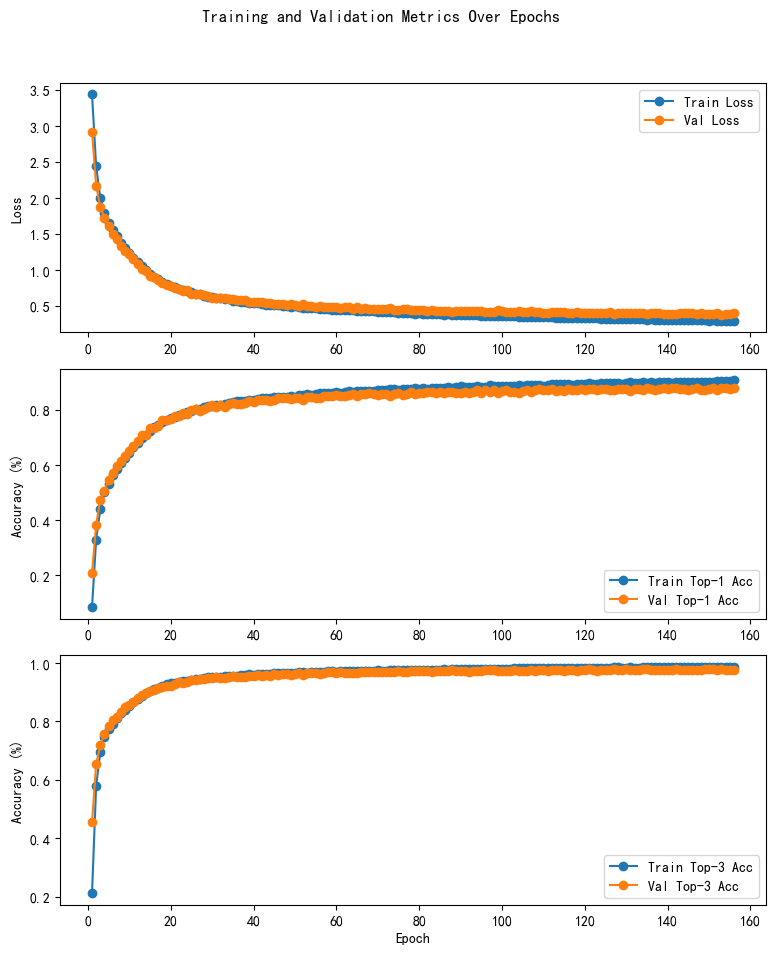

Saved final training metrics plot to training_plots\20250422_235521_training_metrics.png


In [13]:
LeNet5 = train_and_validate(model=LeNet5,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCH,
    device=device,
    save_path="best_model_LeNet5.pth",
    lr=LR)

Epoch [1/500] Loss: 3.4907, Train Top-1 Acc: 0.0720, Train Top-3 Acc: 0.1865, Val Top-1 Acc: 0.1614, Val Top-3 Acc: 0.3836
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.1614
Epoch [2/500] Loss: 2.9748, Train Top-1 Acc: 0.2044, Train Top-3 Acc: 0.4432, Val Top-1 Acc: 0.3636, Val Top-3 Acc: 0.6450
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.3636
Epoch [3/500] Loss: 2.3179, Train Top-1 Acc: 0.3573, Train Top-3 Acc: 0.6547, Val Top-1 Acc: 0.5292, Val Top-3 Acc: 0.8034
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.5292
Epoch [4/500] Loss: 1.8005, Train Top-1 Acc: 0.4951, Train Top-3 Acc: 0.7915, Val Top-1 Acc: 0.6649, Val Top-3 Acc: 0.8841
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.6649
Epoch [5/500] Loss: 1.4153, Train Top-1 Acc: 0.6025, Train Top-3 Acc: 0.8668, Val Top-1 Acc: 0.7150, Val Top-3 Acc: 0.9148
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.7150
Epoch [6/500] Loss: 1.1598, Train Top-1 Acc: 0.6723, Train Top-3 Acc: 0.9005, Val Top-1 Acc: 0.7773, Val Top-3 Acc: 0.9351
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.7773
Epoch [7/500] Loss: 0.9736, Train Top-1 Acc: 0.7211, Train

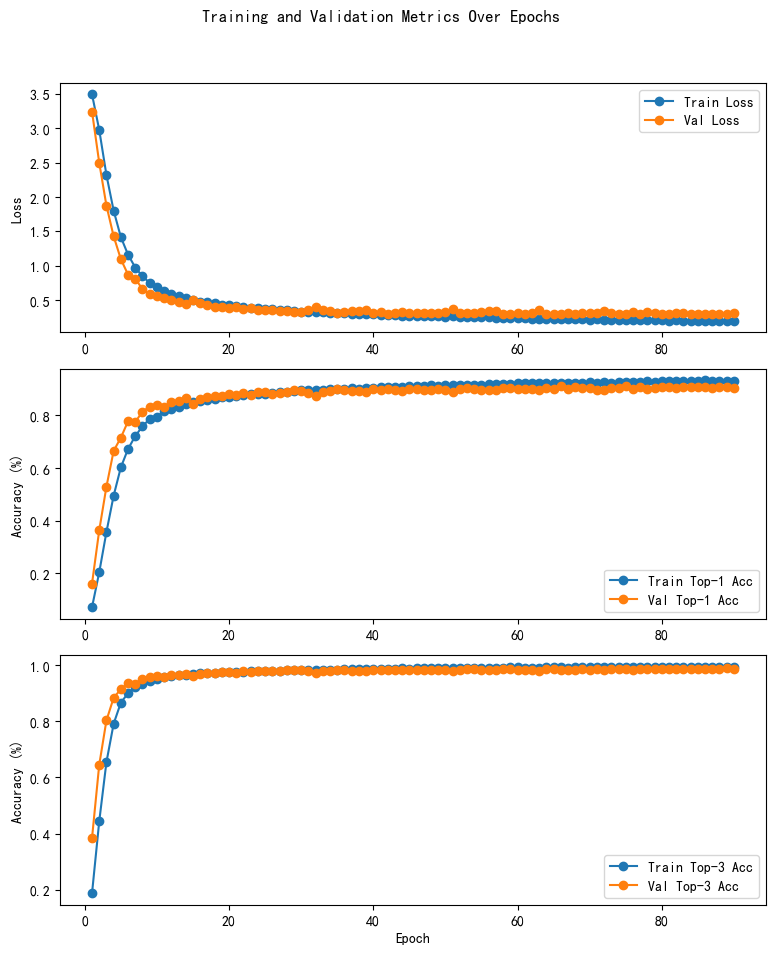

Saved final training metrics plot to training_plots\20250423_001344_training_metrics.png


In [14]:
cnn_with_attention = train_and_validate(model=cnn_with_attention,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCH,
    device=device,
    save_path="best_model_cnn_with_attention.pth",
    lr=LR)

In [15]:
# 模型大小
model_size_resnet18 = sum(p.numel() for p in resnet18.parameters())
model_size_mobilenet_v2 = sum(p.numel() for p in mobilenet_v2.parameters())
model_size_LeNet5 = sum(p.numel() for p in LeNet5.parameters())
# 打印模型大小
print(f"ResNet18 Model Size: {model_size_resnet18} parameters")
print(f"MobileNetV2 Model Size: {model_size_mobilenet_v2} parameters")
print(f"LeNet5 Model Size: {model_size_LeNet5} parameters")

model_sizes = [model_size_resnet18, model_size_mobilenet_v2, model_size_LeNet5]
model_names = ["ResNet18", "MobileNetV2", "LeNet5"]
top1_accs = []
top3_accs = []
inference_speeds = []

ResNet18 Model Size: 11195493 parameters
MobileNetV2 Model Size: 2271269 parameters
LeNet5 Model Size: 47021 parameters


Confusion matrix, without normalization


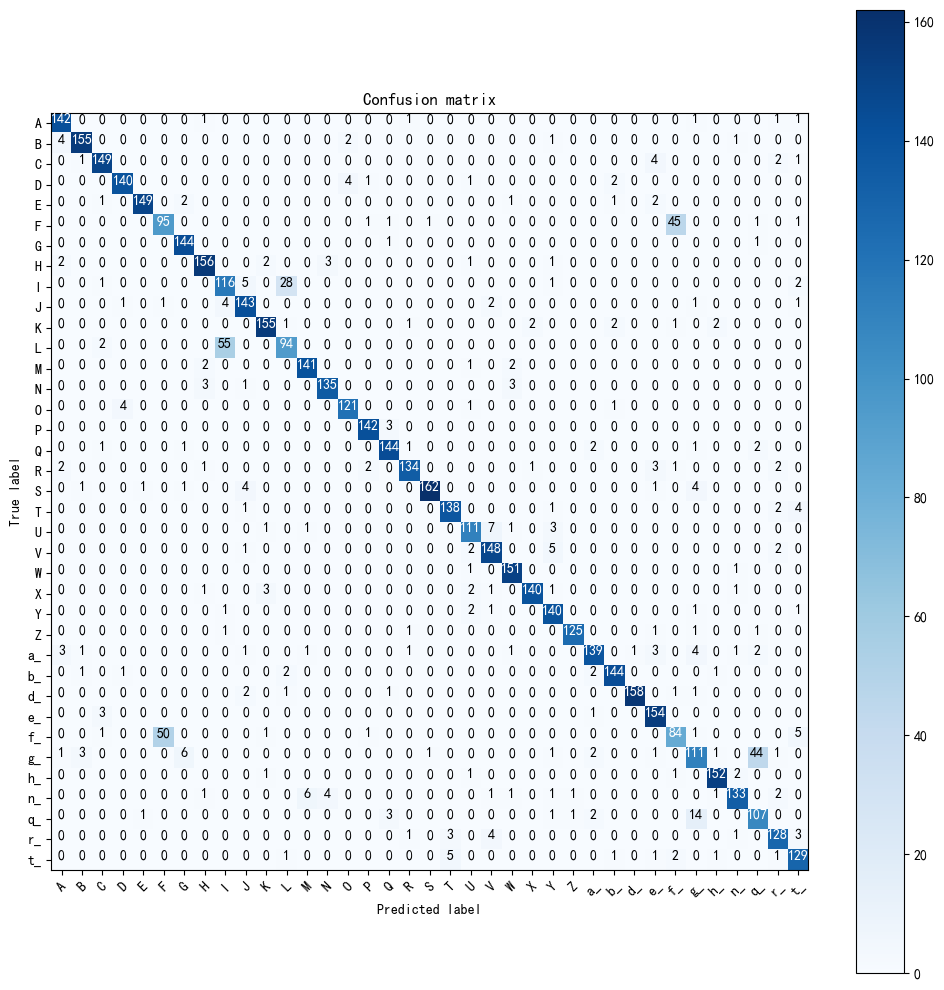

ResNet18 Evaluation:
Top-1 Accuracy: 90.2523
Top-3 Accuracy: 98.8108
Inference Speed: 0.0134 ms per sample


In [16]:
# 推理
top1_acc_resnet18, top3_acc_resnet18, inference_speed_resnet18 = evaluate_model(resnet18, test_loader, device)
top1_accs.append(top1_acc_resnet18)
top3_accs.append(top3_acc_resnet18)
inference_speeds.append(inference_speed_resnet18)
print("ResNet18 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_resnet18:.4f}")
print(f"Top-3 Accuracy: {top3_acc_resnet18:.4f}")
print(f"Inference Speed: {inference_speed_resnet18 * 1000:.4f} ms per sample")

Confusion matrix, without normalization


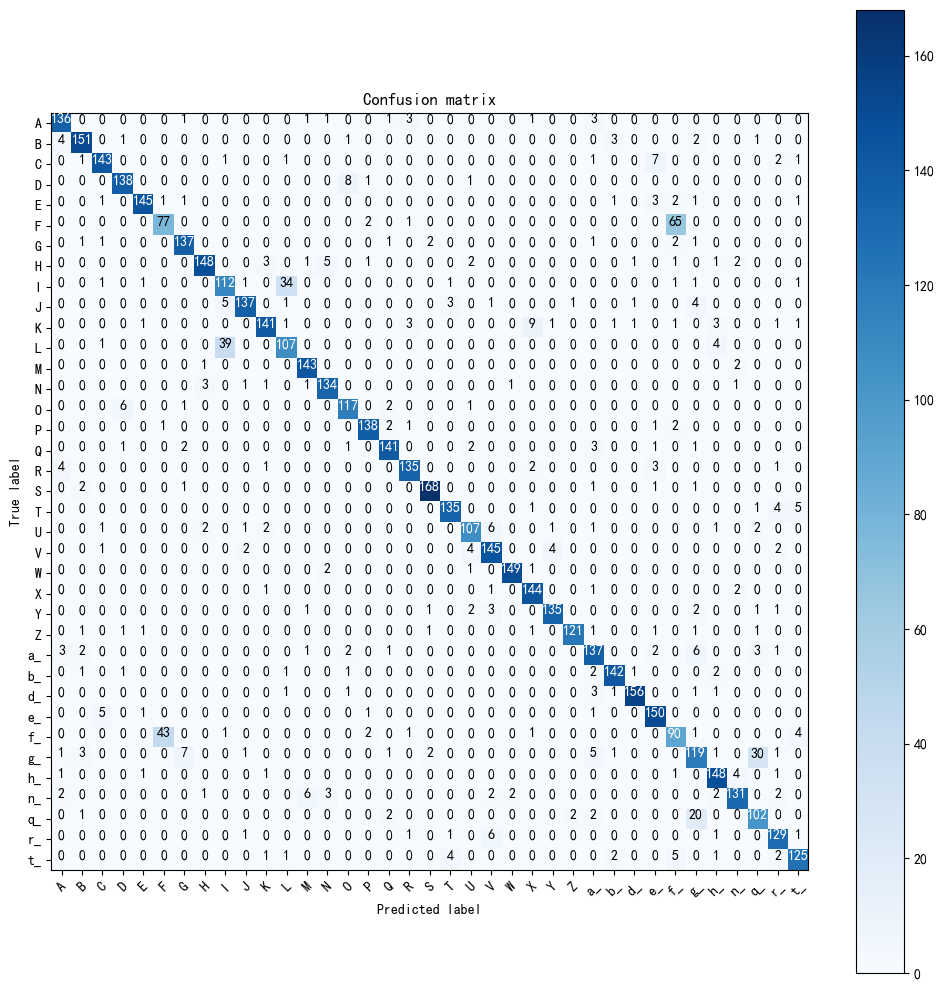

MobileNetV2 Evaluation:
Top-1 Accuracy: 88.5225
Top-3 Accuracy: 98.3063
Inference Speed: 0.0252 ms per sample


In [17]:
top1_acc_mobilenetv2, top3_acc_mobilenetv2, inference_speed_mobilenetv2 = evaluate_model(mobilenet_v2, test_loader, device)
top1_accs.append(top1_acc_mobilenetv2)
top3_accs.append(top3_acc_mobilenetv2)
inference_speeds.append(inference_speed_mobilenetv2)
print("MobileNetV2 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_mobilenetv2:.4f}")
print(f"Top-3 Accuracy: {top3_acc_mobilenetv2:.4f}")
print(f"Inference Speed: {inference_speed_mobilenetv2 * 1000:.4f} ms per sample")

Confusion matrix, without normalization


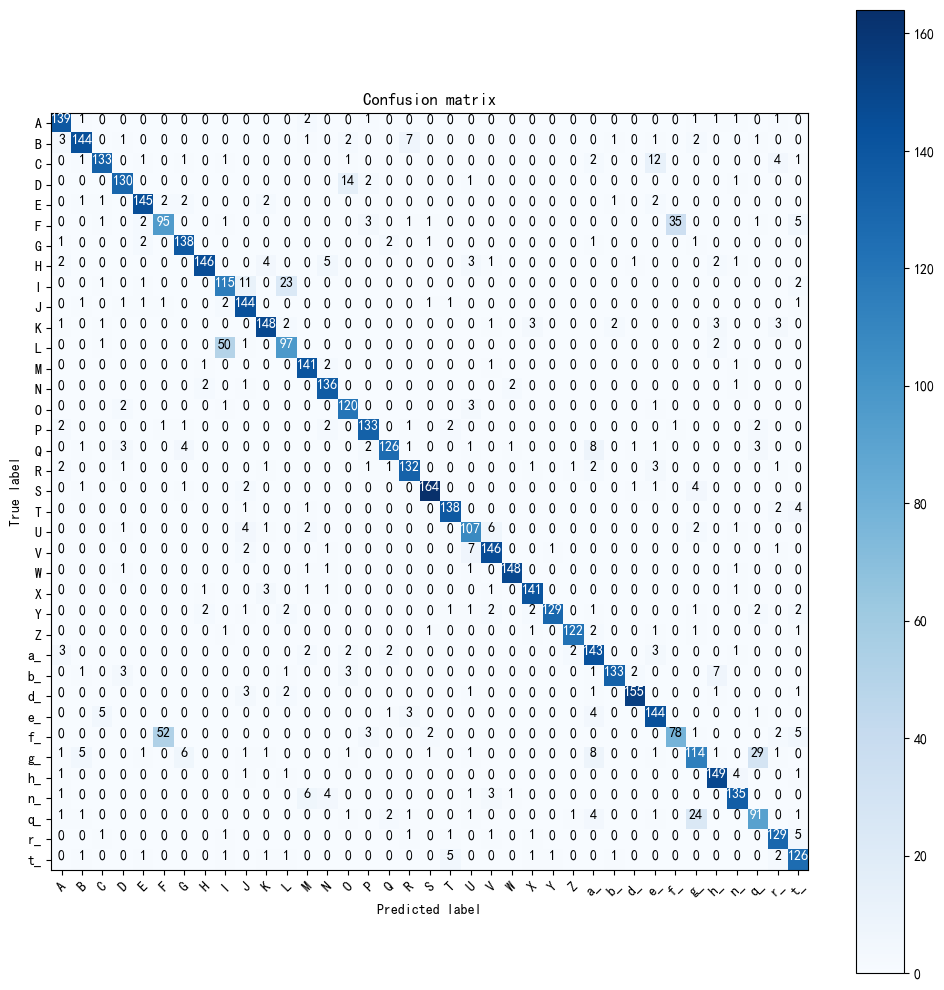

LeNet5 Evaluation:
Top-1 Accuracy: 87.45945945945945
Top-3 Accuracy: 97.58558558558559
Inference Speed: 0.00035917436754381334


In [18]:
top1_acc_LeNet5, top3_acc_LeNet5, inference_speed_LeNet5 = evaluate_model(LeNet5, test_loader, device)
top1_accs.append(top1_acc_LeNet5)
top3_accs.append(top3_acc_LeNet5)
inference_speeds.append(inference_speed_LeNet5)
print("LeNet5 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_LeNet5}")
print(f"Top-3 Accuracy: {top3_acc_LeNet5}")
print(f"Inference Speed: {inference_speed_LeNet5 * 100}")

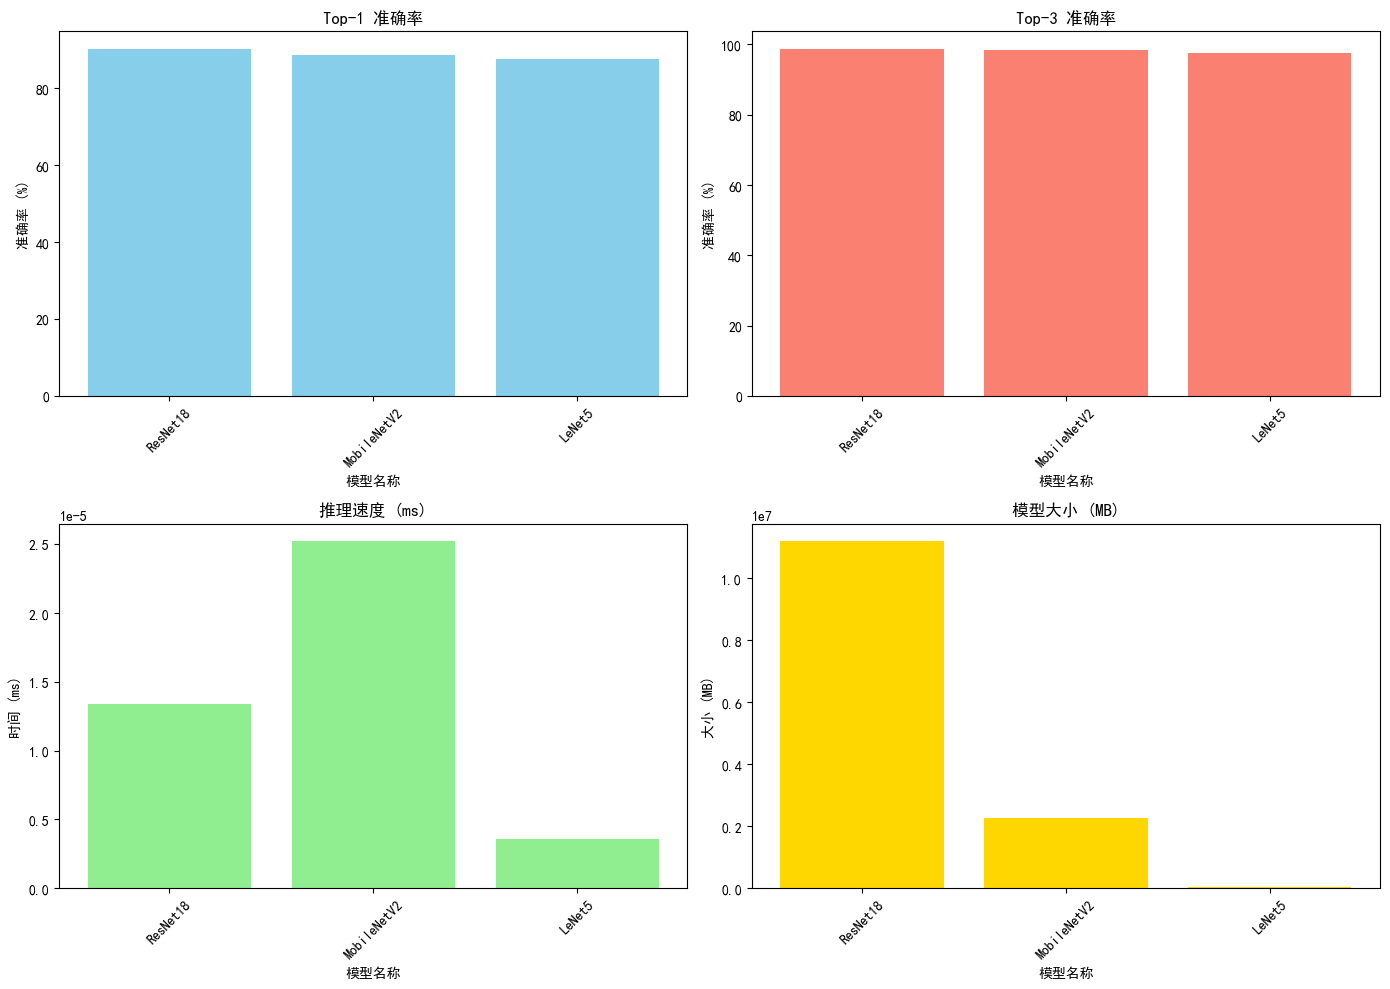

In [19]:
plot_comparison(model_names, top1_accs, top3_accs, inference_speeds, model_sizes)
